# Fairness Analysis of the UTK FACE Baseline Models

Analysis of the test set with regard to the gender prediction.

In [1]:
from IPython.display import display, Markdown, Latex
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
colors = ['#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c']



dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    },
    'age_id': {
        0: '<10',
        1: '10-20',
        2: '20-30',
        3: '30-40',
        4: '40-60',
        5: '60-80',
        6: '80+'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())
dataset_dict['age_alias'] = dict((a, i) for i, a in dataset_dict['age_id'].items())

In [2]:
# read csv with predictions from the model
predictions_path = r"C:\Users\thoma\Documents\_FAIRALGOS\utk-fairness-analysis\Predictions\df_predctions_all.csv"
df_predictions = pd.read_csv(predictions_path, index_col=0)

# analysis with regard to the gender prediction only -> dropping age and race predictions
df_bld = df_predictions.drop(columns=['age_pred', 'race_pred']).rename(columns={'age_true': 'age', 'race_true': 'race'})

# transforming gender_true and gender_pred into a single attribute if the prediction was correct
pred_true = []
for i, row in df_bld.iterrows():
    if(row['gender_true'] == row['gender_pred']):
        pred_true.append(1)
    else:
        pred_true.append(0)

df_bld['pred_true'] = pred_true
df_bld = df_bld.drop(columns=['gender_pred']).rename(columns={'gender_true': 'gender'})

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
# cutting the age into bins
age_binned = pd.cut(df_bld['age'], bins, labels=[0,1,2,3,4,5,6])
df_bld['age'] = age_binned

In [3]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# fairness metrics
def fairness_summary(bld_metric, plot=True, description=""):
    summary = {'base_rate_priviledged': bld_metric.base_rate(privileged=True),
     'base_rate_unpriviledged': bld_metric.base_rate(privileged=False),
     'consistency': bld_metric.consistency()[0],
     'disparate_impact': bld_metric.disparate_impact(),
     'mean_difference': bld_metric.mean_difference(),
     'smoothed_empirical_differential_fairness': bld_metric.smoothed_empirical_differential_fairness(concentration=1.0)}


    if plot:
        metrics = ['brp', 'bru', 'con', 'dis', 'mdf', 'sed']
        values = summary.values()

        sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

        fig, ax = plt.subplots(1, 1)
        ax.bar(metrics, values, color=colors, zorder=3)
        ax.grid(zorder=0, color='#D3D3D3')
        plt.title(f"Fairness metrics: {description}", fontsize=14)

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(1.5, 0.95, str(summary).replace(',', '\n').replace('{', '').replace('}', ''), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

        plt.show()

    return summary

# one vs rest groupings
def one_vs_rest_df(df, conditions={'race': 1, 'gender': 1}):
    # conditions is a dictionary with column - value pairs

    # 1 equals rest, 0 equals subgroup
    groups = []
    for i, row in df.iterrows():
        group = 0 # assume subgroup until on condition fails
        for column, value in conditions.items():
            if(row[column] != value):
                group = 1
                break
        groups.append(group)

    new_df = df.copy()
    new_df['group'] = groups

    return new_df


bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=['race'])
bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'race': 2}], privileged_groups=[{'race': 0}])


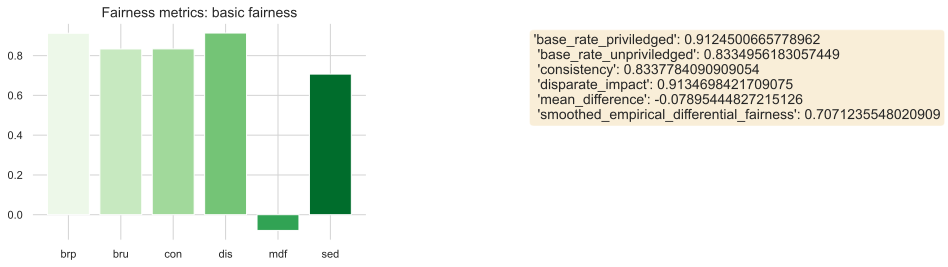

{'base_rate_priviledged': 0.9124500665778962,
 'base_rate_unpriviledged': 0.8334956183057449,
 'consistency': 0.8337784090909054,
 'disparate_impact': 0.9134698421709075,
 'mean_difference': -0.07895444827215126,
 'smoothed_empirical_differential_fairness': 0.7071235548020909}

In [4]:
fairness_summary(bld_metric, description="basic fairness")

## One vs Rest analysis

## One vs Rest by Race

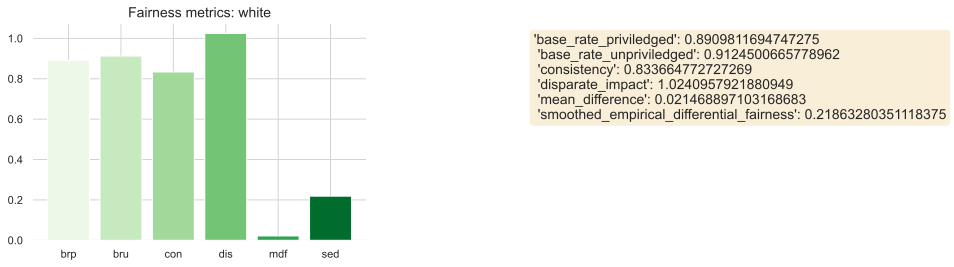

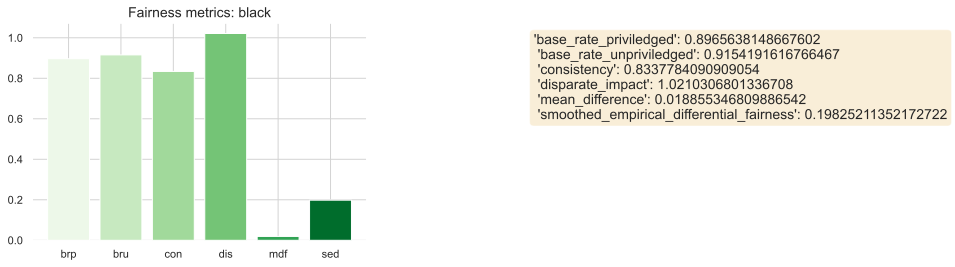

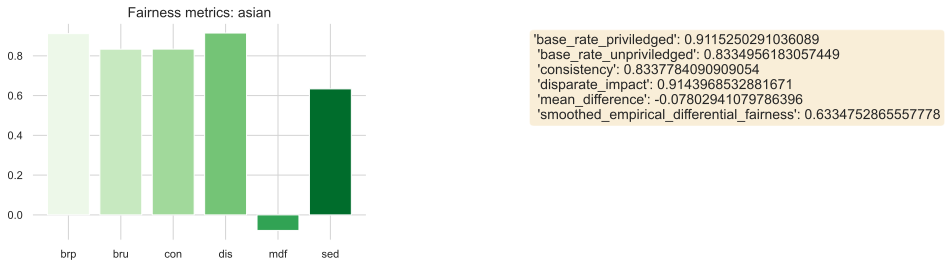

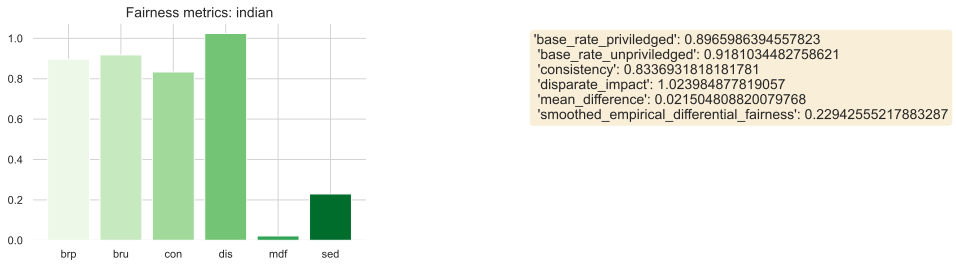

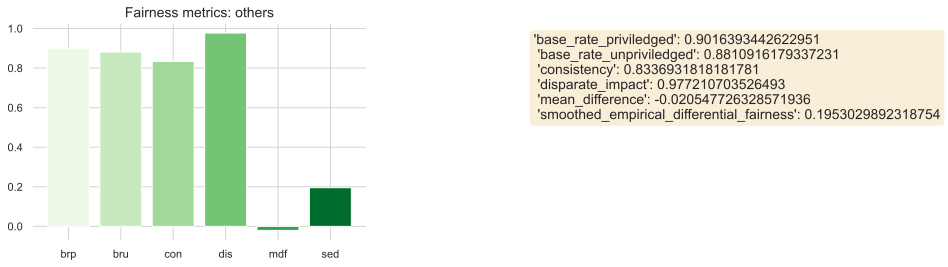

In [5]:
display(Markdown("## One vs Rest by Race"))

#onevsresst for race
for race_id, race_alias in dataset_dict['race_id'].items():
    df_sub = one_vs_rest_df(df_bld, conditions={'race': race_id})
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
    fairness_summary(bld_metric, description=race_alias)

## One vs Rest by gender

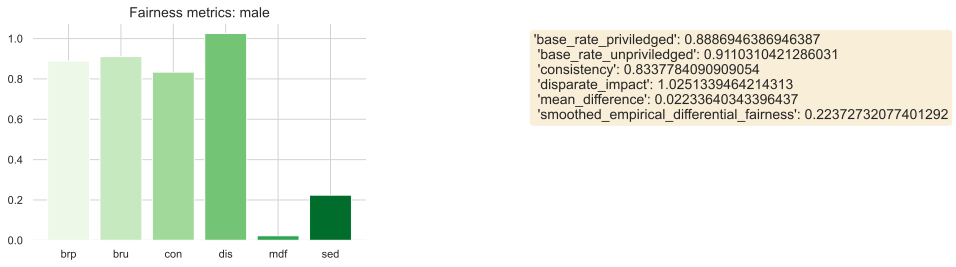

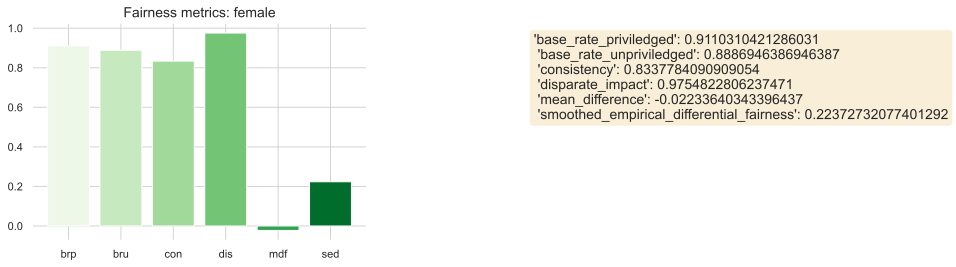

In [6]:
#onevsresst for gender

display(Markdown("## One vs Rest by gender"))

for gender_id, gender_alias in dataset_dict['gender_id'].items():
    df_sub = one_vs_rest_df(df_bld, conditions={'gender': gender_id})
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
    fairness_summary(bld_metric, description=gender_alias)

## One vs Rest by age

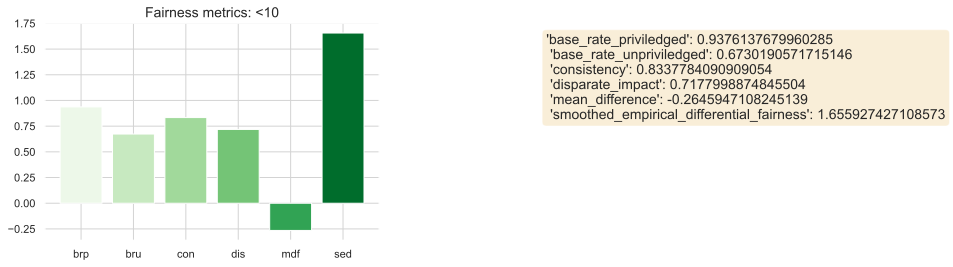

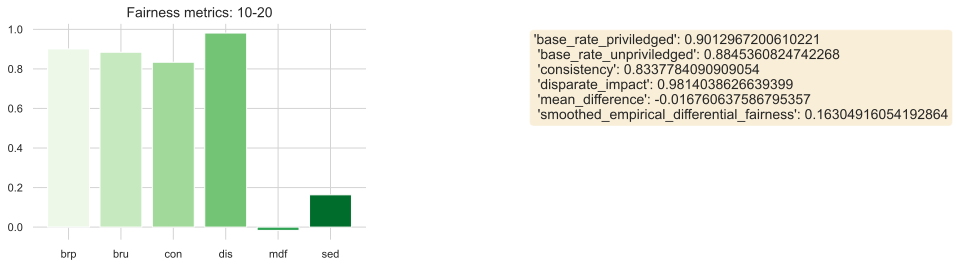

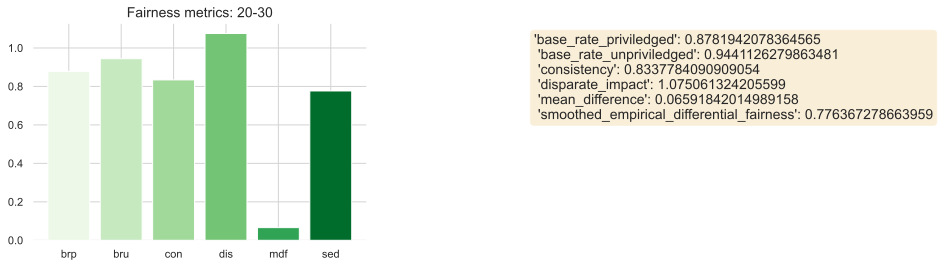

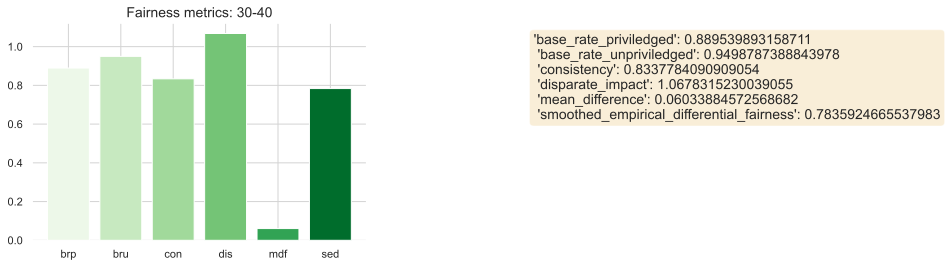

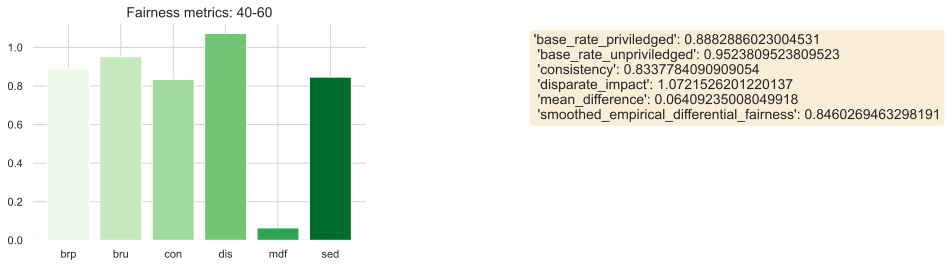

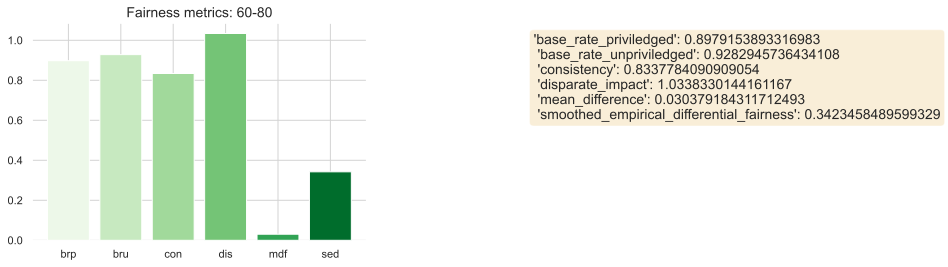

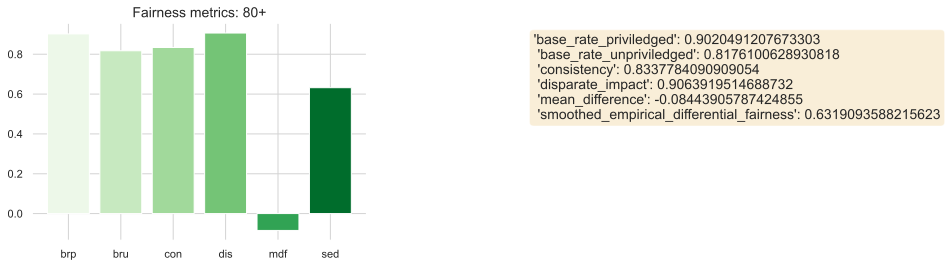

In [7]:
#onevsresst for age

display(Markdown("## One vs Rest by age"))

for age_id, age_alias in dataset_dict['age_id'].items():
    df_sub = one_vs_rest_df(df_bld, conditions={'age': age_id})
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
    fairness_summary(bld_metric, description=age_alias)

## Intersectional One vs Rest

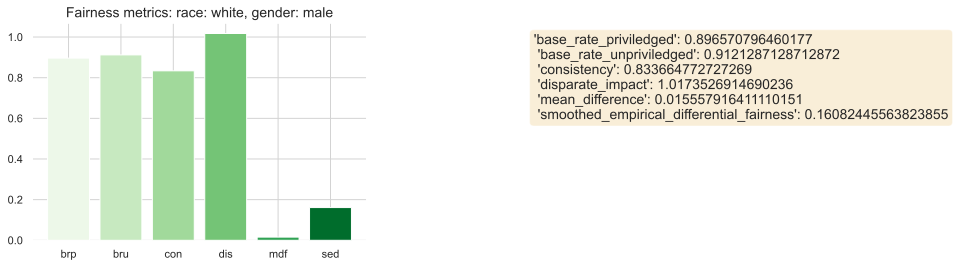

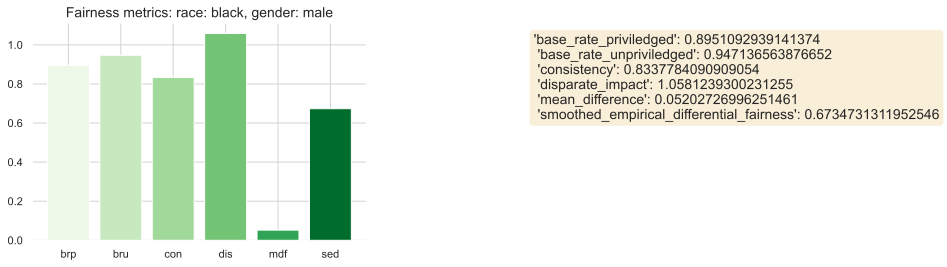

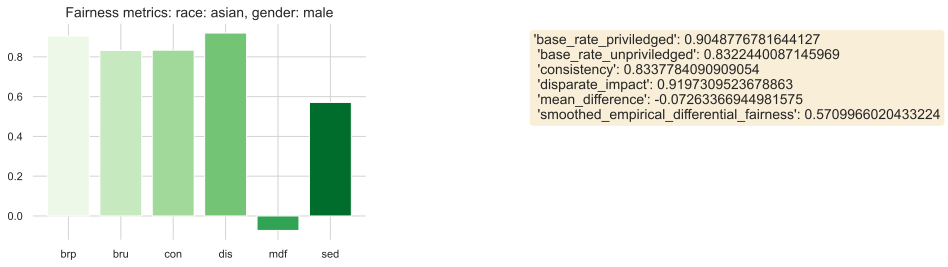

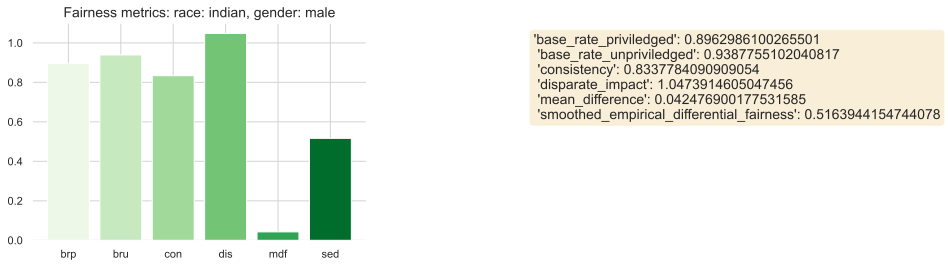

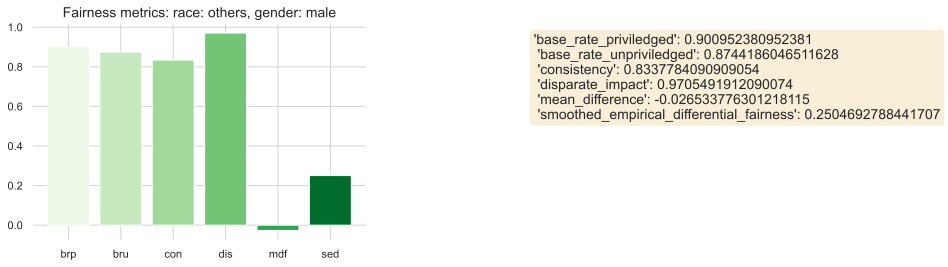

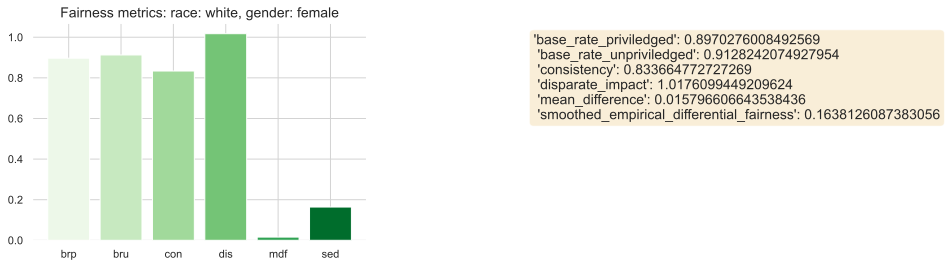

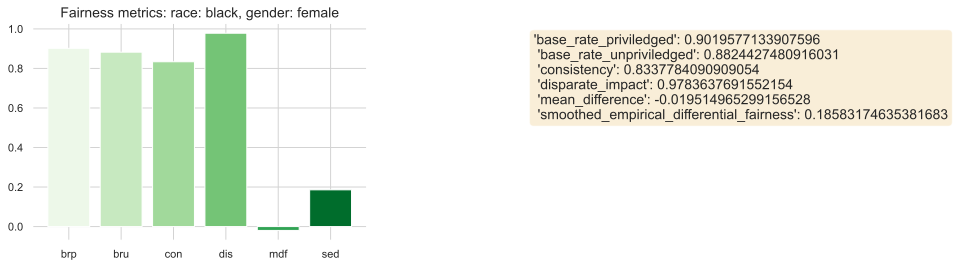

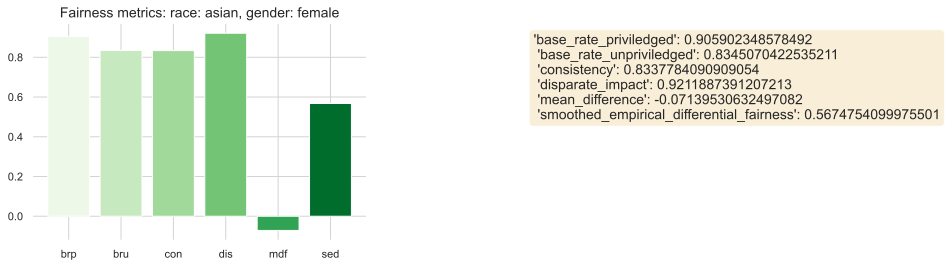

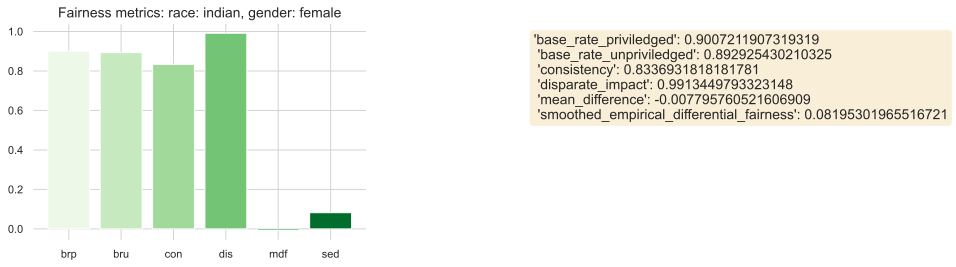

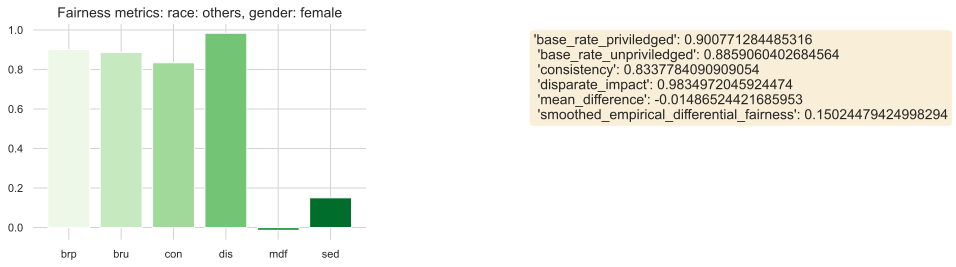

In [8]:
for gender_id, gender_alias in dataset_dict['gender_id'].items():
    for race_id, race_alias in dataset_dict['race_id'].items():
        df_sub = one_vs_rest_df(df_bld, conditions={'race': race_id, 'gender': gender_id})
        bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
        bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
        fairness_summary(bld_metric, description=f"race: {race_alias}, gender: {gender_alias}")